# A Quick Tour of `Litmus`
Welcome to `LITMUS`, a quick, easy and robust way to do lag recovery from time series data. This has been purpose built to do lag recovery in seasonal AGN reverberation mapping campaigns like OzDES and SDSS, but can be used for estimating delays between any signals you might want. This tutorial acts as an overview of the structure of the program, as well as a start-to-finish example of how to fit lags for real world data.

This is only a bare-bones tutorial, showing the most basic approach to using `LITMUS`. For details on the advances features, consult the other tutorials.

In [113]:
import litmus.models
from litmus import *
import matplotlib.pyplot as plt
import numpy as np
from litmus._utils import dict_extend

## Lightcurves & Importing Data

`LITMUS` stores signals in `lightcurve` objects. These aren't really any more complicated than a dictionary or array, they just have a few bells and whistles on them to make them easier to transport and manipulate. They're loaded in a pretty straightforward way: first, make sure you have time, signal value and uncertainties as lists. 

Here I've prepared some in `.csv` files which I load with `numpy`. Note that these are mock AGN lightcurves where we know the true lag is $\Delta t = 300 \; \mathrm{d}$:

In [114]:
T1, Y1, E1 = np.loadtxt("./lc_1.csv", delimiter=",", unpack=True)
T2, Y2, E2 = np.loadtxt("./lc_2.csv", delimiter=",", unpack=True)

Then we turn these into `lightcurve` objects in a pretty straightforward way:

In [115]:
lc_1 = litmus.lightcurve(T=T1, Y=Y1, E=E1)
lc_2 = litmus.lightcurve(T=T2, Y=Y2, E=E2)

When loading lightcurves, you can double-check they're working with the `.plot()` method, which can be aimed at specific `maplotlib` axes. You can also access all of the data with the attributes `,T, .Y` and `.E`:

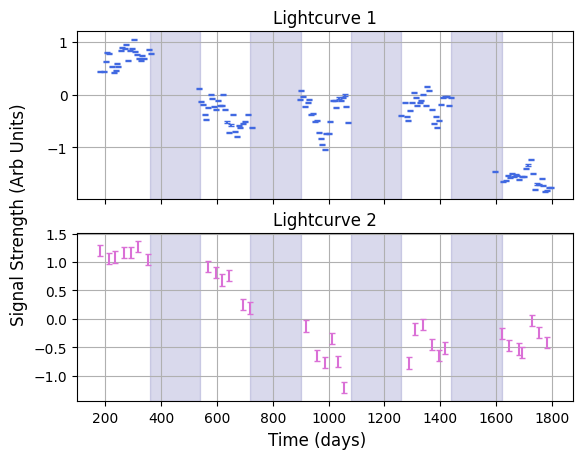

In [116]:
f, [a1, a2] = plt.subplots(2, 1, sharex=True, sharey=False)
lc_1.plot(axis=a1, show=False, c='royalblue', capsize=2), lc_2.plot(axis=a2, show=False, c="orchid", capsize=2)
a1.grid(), a2.grid()
a1.set_title("Lightcurve 1"), a2.set_title("Lightcurve 2")
f.supxlabel("Time (days)")
f.supylabel("Signal Strength (Arb Units)")

for i in range(1, 5):
    for a in [a1, a2]: a.axvspan(180 * 2 * i, 180 * (2 * i + 1), color = 'navy', alpha=0.15, zorder=-1)

plt.show()

Many of `LITMUS`' s fitters also try to constrain the mean and amplitude of signals. We can see that, in our data, the two lightcurves have different scales / units. We _could_ manually adjust our model prior ranges to fit them, or we could take the easy route and just squash the signals, normalizing to have a near zero mean and near unitary width:

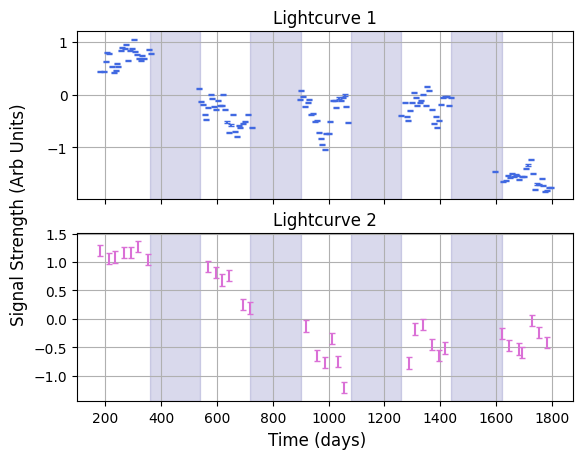

In [117]:
lc_1.normalize(), lc_2.normalize()

#----------
f, [a1, a2] = plt.subplots(2, 1, sharex=True, sharey=False)
lc_1.plot(axis=a1, show=False, c='royalblue', capsize=2), lc_2.plot(axis=a2, show=False, c="orchid", capsize=2)
a1.grid(), a2.grid()
a1.set_title("Lightcurve 1"), a2.set_title("Lightcurve 2")
f.supxlabel("Time (days)")
f.supylabel("Signal Strength (Arb Units)")
for i in range(1, 5):
    for a in [a1, a2]: a.axvspan(180 * 2 * i, 180 * (2 * i + 1), color = 'navy', alpha=0.15, zorder=-1)
plt.show()

## Models
`LITMUS` is a Bayesian fitting package, which means it assumes an explicit underlying model for the signals for which we reverse engineer the parameters (including lag). Unlike other lag recovery packages, `LITMUS` allows for _multiple_ models which can be applied interchangeably. The full suite of available models can be found in the `litmus.models` module.

For AGN reverberation mapping, we know the signals follow close to a Gaussian Process, specifically that the photometric lightcurve follows a damped random walk (DRW) and that the response is a "scaled shifted and delayed copy" of this DRW. This model is encoded in `GP_simple`, and all we need to do is create an instance of it. For demonstration, let's make this model with a custom prior range for its lag, allowing for negative lags in the `SDSS` style instead of `LITMUS`'s default of positive lags only:

In [118]:
model = litmus.models.GP_simple(prior_ranges={"lag": [-1000.0, 1000.0]})

Now lets take a look at what parameters / prior ranges the model has overall:

In [119]:
model.prior_ranges

{'lag': [-1000.0, 1000.0],
 'logtau': [0.0, 10.0],
 'logamp': [-3.0, 3.0],
 'rel_amp': [0.0, 10.0],
 'mean': [-20.0, 20.0],
 'rel_mean': [-10.0, 10.0]}

## Fitting Methods
Now that we have data and a statistical model, we need a _numerical_ model to actually do the fitting for us. In `LITMUS` these exist in the of the `litmus.fitting_methods` module. We probably want to use the `hessian_scan`, as it's the fastest and easiest of the methods. 

If you're trying to do model comparison you can also use the `SVI_scan`, which is a little slower but more accurate in terms of its integrals. Nested Sampling goes further still, giving more robust results but is much slower than either of the scans method. Also available is an implementation of ICCF, which is moderately fast but _very_ imprecise, and doesn't fit any actual stats models. See specific tutorials on these fitting methods for more details. 

In [216]:
fitter = litmus.fitting_methods.hessian_scan(model, Nlags=128)
fitter.fit(lc_1, lc_2)

Starting Hessian Scan 
Running final optimization... 
Making Grid with interp scale log 
Prefitting Complete 
Scanning Complete. Calculating laplace integrals... 
Hessian Scan Fitting complete.
-----------------------
-----------------------



Before we proceed, we want to make sure our fits has converged properly. The easiest way to do this is to use the `.diagnostics()` and `.diagnostic_lagplot()`methods: inbuilt tools for different `fittin_method`s that produce plots to check if everything's running smoothly.

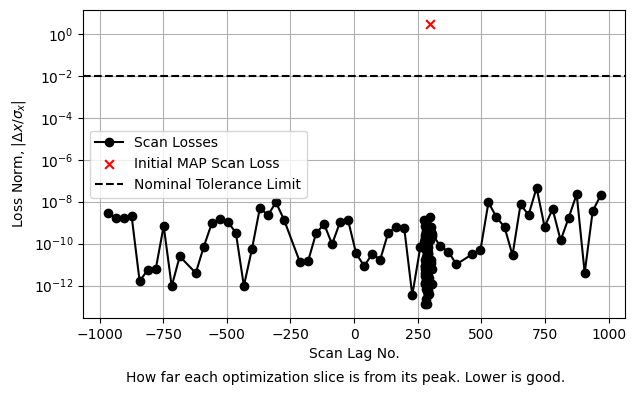

In [217]:
fitter.diagnostics()
plt.show()

For `hessian_scan`, this diagnostic plot shows the approximate distance (in standard deviations) each Gaussian slice's peak is away from the true peak. The dotted line here shows the nominal tolerance limit for the fitter, in this case about $1%$, meaning each slice is more than $99 \%$ converged. Looks like one or two slices might be a bit off - this isn't a huge deal as it normally indicates these were bad fits anyway. Still, let's `.refit()` them:

In [218]:
fitter.refit(lc_1, lc_2)

Doing re-fitting of 0 lags 
Refitting complete. 


Next we can check the `diagnostic_lagplot()` plot. For `hessian_scan` this shows how the test lags integrals are spaced on linear (top) and logarithmic (bottom) axes. We want to make sure we've mapped out a decent chunk of the posterior, i.e. that the peak (shaded region) has more than a few datapoints in there:

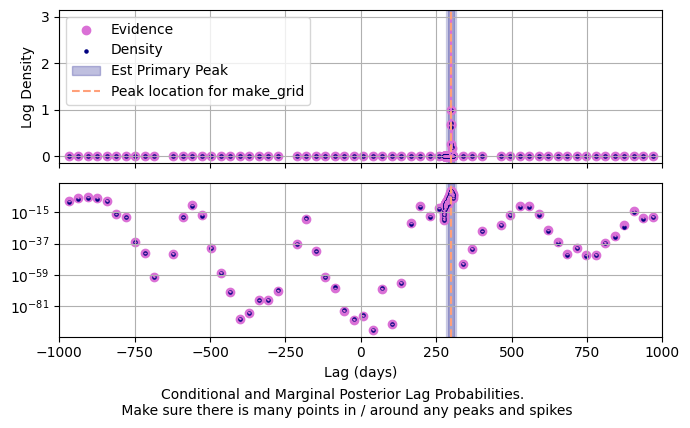

In [219]:
fitter.diagnostic_lagplot()
plt.show()

Sure enough, our results are looking properly converged. That means we can start to pull results out. We can get MCMC-like samples directly from the fitter with `get_samples()`:

In [220]:
samples = fitter.get_samples(32_000)
best_lag = fitter.get_peaks()["lag"]

lag_med = np.median(samples["lag"])
lag_plus = np.percentile(samples["lag"], 84) - np.median(samples["lag"])
lag_minus = np.median(samples["lag"]) - np.percentile(samples["lag"], 16)
print("Median lag is %.2f +/- (%.2f, -%.2f)" %(lag_med, lag_plus, lag_minus))

Median lag is 299.07 +/- (0.88, -0.99)


These samples can be plotted just like those from an MCMC chain, including to get a map of the posterior probability density for the lag:

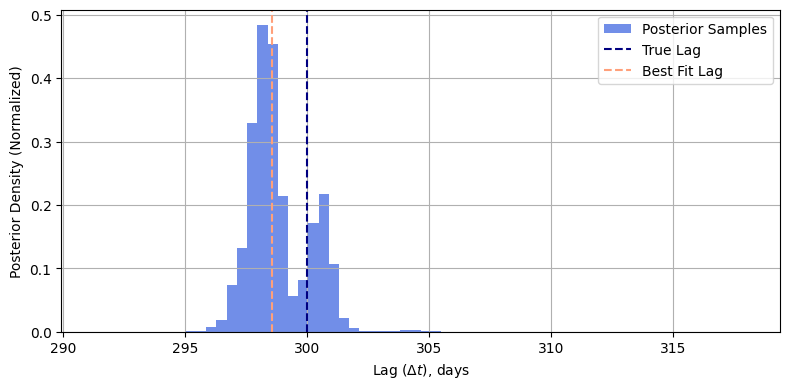

In [215]:
plt.figure(figsize=(8,4))
plt.hist(samples["lag"], range=(lag_med - lag_minus*10,lag_med + lag_plus*10), bins = 64, density=True, color = "royalblue", alpha=0.75, label = "Posterior Samples")
plt.grid()
plt.axvline(300.0, label = "True Lag", ls='--', color = "navy")
plt.axvline(best_lag, label = "Best Fit Lag", ls='--', color = "lightsalmon")
plt.xlabel("Lag ($\Delta t$), days")
plt.ylabel("Posterior Density (Normalized)")
plt.tight_layout()
plt.grid(True)
plt.legend()

plt.show()

`LITMUS` also has a pre-made plotting object, handily named the `litmus` object. If you feed it a fitting method (that has already been run), you can tell it to `plot_parameters` to show how it's constrained _all_ parameters. Again, this is a mock signal with known parameters, so we can check to see how well we've done:

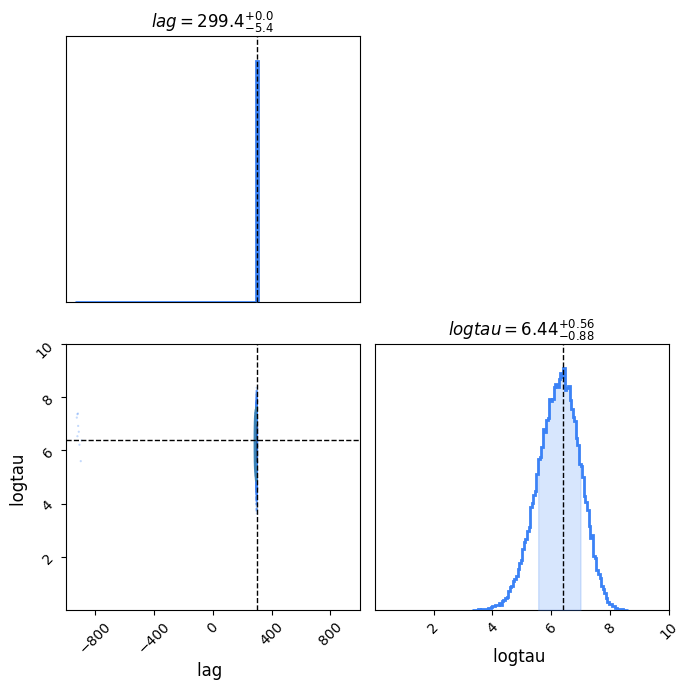

In [228]:
lt = litmus.LITMUS(fitter)
lt.plot_parameters(prior_extents=True, params = ["lag", "logtau"],
                   truth = {"lag":300.0, "logtau":np.log(600.0)})
plt.show()

The `litmus` plotter also has a `lag_plot` to show how well it's constrained the lag:

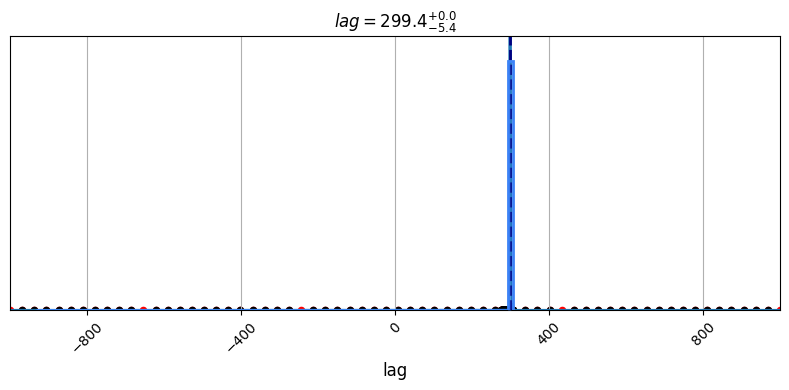

In [231]:
lt.lag_plot(truth={"lag":300.0})
plt.show()

Finally, if we wanted to do model comparison, we can get an estimate of the model evidence using `.get_evidence()`. The uncertainty here is pretty high because of the grid spacing we used, but we've still managed to constrain magnitude of the evidence (it's log evidence we typically compare for models) to a pretty good margin:

In [233]:
Z, E_zplus, E_zminus = fitter.get_evidence()
print("Model Evidence is %.2e +/- (%.2e, %.2e)" %(Z, E_zplus, E_zminus ))

Model Evidence is 4.23e+12 +/- (-1.89e+11, 1.89e+11)


And that's your first `LITMUS` run! Consult the individual tutorials for how to use specific fitting methods, best practice for calculating evidences for model comparison, and general debugging and problem solving in edge cases. 

Good luck!